# Incorporating network structure into coupled cytoskeletal network

## Headers and functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import PyDSTool as dst
import numpy as np
import numpy.random as random
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc
import networkx as nx
import pandas as pd
from tqdm import tqdm
import pickle
plt.rcParams['figure.figsize']=10,5
def makeheatmap(string,pointset):
    pts=pointset
    col=[]
    mat=[]
    for j in range(0,len(pts[string+'0'])):
        for i in range(0, COMPARTMENTS):
            col.append(pts[string+str(i)][j])
        mat.append(col)
        col=[]
    mat.reverse()
    #mat.transpose()
    fig,ax=plt.subplots()
    ax=sns.heatmap(mat,cmap="YlGnBu")
    
def initialLdist(COMPARTMENTS,maxL,s):
    x=np.linspace(0,2.0,COMPARTMENTS+1)
    L=[]
    for i in range(0,len(x)):
        L.append(maxL*np.exp(-((x[i]-1.0)/s)**2))
    return L

def actindefinition(edgelist):
    A=edgelist
    vardict={}
    for n in A.keys():
        ASSIGNMENT="gamma_actin*(shs(S,kactin*RacGTP"+n+"-k_actin_degr*"
        numNeigh=len(A[n])
        ASSIGNMENT=ASSIGNMENT+"("+str(numNeigh)+"*Actin"+n
        for nei in A[n]:
            ASSIGNMENT=ASSIGNMENT+"-Actin"+nei
        ASSIGNMENT=ASSIGNMENT+"+w_actin))-Actin"+n+")"
        vardict['Actin'+n]=ASSIGNMENT
    return vardict

def myosindefinition(edgelist):
    A=edgelist
    vardict={}
    for n in A.keys():
        ASSIGNMENT="shs(S,kmyosin*RhoA"+n+"-k_degr_myosin*"
        numNeigh=len(A[n])
        ASSIGNMENT=ASSIGNMENT+"("+str(numNeigh)+"*Myosin"+n
        for nei in A[n]:
            ASSIGNMENT=ASSIGNMENT+"-Myosin"+nei
        ASSIGNMENT=ASSIGNMENT+"))-Myosin"+n
        vardict['Myosin'+n]=ASSIGNMENT
    return vardict

# Watts-Strogatz randomization

In [2]:
# Generating random graphs 
N=360
K=4


n=N #int(raw_input('Please enter number of nodes in graph: ') or "10")
if n<=0:
    sys.exit('n has to be positive!')

nodelist=np.arange(0,n)
k=K #int(raw_input('Please enter average degree of each node.\nFor n=%i, enter an even integer between 1 and n: ' % n) or '2')
if k%2 !=0:
    sys.exit('k is not even!')
if k >n:
    sys.exit('k is too large!')

degreecount=np.arange(-k/2,(k+2)/2)
G=nx.Graph()

for i in range(0,len(nodelist)):
    for j in range(0,len(degreecount)):
        if i+degreecount[j]>n-1:
            G.add_edge(str(nodelist[i]),str(nodelist[i+degreecount[j]-n-1]))
            #print i,"\t",j,"\t",nodelist[i],nodelist[i+degreecount[j]-n-1]
        else:
            if nodelist[i+degreecount[j]]!=nodelist[i]:
                G.add_edge(str(nodelist[i]),str(nodelist[i+degreecount[j]]))

#f.close()
for node in G.nodes():
    if node in G.neighbors(node):
        G.remove_edge(node,node)
        print "removed an edge"
def rewire(H,p): 
#Function takes in a graph and a probability p, and returns average shortest path length and average clustering coefficient of the rewired graph    
    nodeset=set(H.nodes())

    for node in H.nodes(): #rewiring
        neighborset=set(H.neighbors(node))
        targetlist=list(nodeset-neighborset)
        for tailnode in H.neighbors(node):
            r=random.random()
            if r<p:
                node_selection=random.randint(0,len(targetlist)-1)
                H.remove_edge(node,tailnode)
                H.add_edge(node,targetlist[node_selection])
    #asp=[]
    return H
def generate_adlist(G):
    node=G.nodes()
    neighbors={}
    for e in G.edges():
        for n in node:
            neighbors[n]=G.neighbors(n)
    return neighbors

removed an edge


# Generate and store adjacency lists for rewired graphs

In [56]:
beta=list(np.logspace(-3.0,-1.56,5)) # Specify probabilities of rewiring
#P=[0.01]
beta.insert(0,0.0)
Adict=[]
for b in beta:
    A={}
    graph=rewire(G.copy(),b)
#     graph=graph.to_undirected()
#   graph=rewire(G,0.15)
    A=generate_adlist(graph)
    Adict.append(A)
#B=generate_adlist(G)

# Model  definition

In [57]:
COMPARTMENTS=N-1

RevisedCompArgs=dst.args(name='small-world-cyto',
        varspecs={
        # input set to constant initial value by default
        'L[i]':'for(i,0,'+str(COMPARTMENTS)+',0)',#kp-klr*L[i]*R[i]-kd)',
        'PIP[i]':'for(i,0,'+str(COMPARTMENTS)+',gamma_pip*(shs(S,wlr*L[i]*R[i]-wpip)-PIP[i]))',
        # Regulators
        'RacGTP[i]':"for(i,0,"+str(COMPARTMENTS)+",shs(S,-w_rac_rac*RacGTP[i]+w_rac_pip*PIP[i])-RacGTP[i])",
        'RhoA[i]':"for(i,0,"+str(COMPARTMENTS)+",(shs(S,wlr_rho*L[i]*R[i]-w_actin_rho*Actin[i])-RhoA[i]))",                   
    },
        pars={
# PIP Parameters
        'wpip':0.45,     
        'gamma_pip':0.5,
        'wlr':1.0,       
# RacGTP activation
        'w_rac_pip':3.0, 
# Rac
        'w_rac_rac':1.5,
# Rho
        'w_actin_rho':6.0,
        'wlr_rho':1.0,               
        'S':10,
        'kactin':1.0,#0.1,
        'w_actin':0.77,
        'k_actin_degr':1.0,
        'gamma_actin':10.0,
        'kmyosin':1.0,
        'k_degr_myosin':10
    },
                       ics={
    },
                       fnspecs={
        'shs':(['sig','summ'],'1.0/(1.0+exp(-sig*summ))'),
        'actinweight':(['n','denom'],'n/denom')
                               },
                       tdata=[0,20]
                       )
SimData=[]
for A in tqdm(Adict):
    act=[]
    RevisedCompArgs.varspecs.update(actindefinition(A))
    RevisedCompArgs.varspecs.update(myosindefinition(A))
    # RevisedCompArgs.varspecs.update(actindefinition(B))
    # RevisedCompArgs.varspecs.update(myosindefinition(B))
    #s=[0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]
    s=[0.5]
    AMRatio=[]
    #for v in s:
    L=initialLdist(COMPARTMENTS,1.5,s)
    Rinitial=1.0
    PIPinitial=0.0
    Racinitial=0.0
    Actininital=0.0
    Rhoinitial=0.0
    Myosininitial=0.0
    for i in range(0,COMPARTMENTS+1):
        R=str('R'+str(i))
        RevisedCompArgs.pars[R]=Rinitial
        PIP=str('PIP'+str(i))
        RevisedCompArgs.ics[PIP]=PIPinitial
        Rac=str('RacGTP'+str(i))
        RevisedCompArgs.ics[Rac]=Racinitial
        Actin=str('Actin'+str(i))
        RevisedCompArgs.ics[Actin]=Actininital
        Rho=str('RhoA'+str(i))
        RevisedCompArgs.ics[Rho]=Rhoinitial
        Myosin=str('Myosin'+str(i))
        RevisedCompArgs.ics[Myosin]=Myosininitial
        Lval=str('L'+str(i))
        RevisedCompArgs.ics[Lval]=L[i]
    RevisedCompDS=dst.Vode_ODEsystem(RevisedCompArgs)
    pts=RevisedCompDS.compute('test').sample(dt=0.5)
    SimData.append(pts)
len(SimData)

6

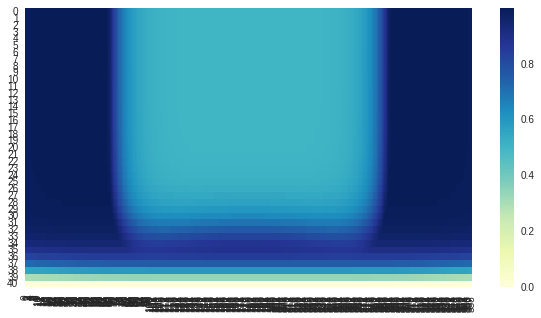

In [39]:
# Example of makeheatmap() usage
makeheatmap('Myosin',SimData[0])

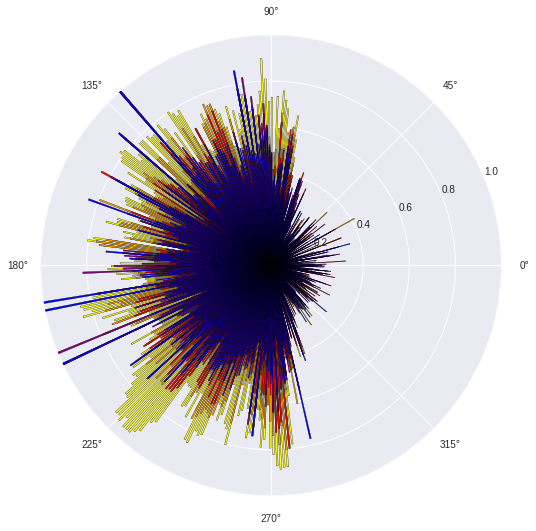

In [48]:
def minmaxglobal(Llist):
    maxglob=[]
    minglob=[]
    for L in Llist:
        maxglob.append(max(L))
        minglob.append(min(L))
    mini=min(minglob)
    maxi=max(maxglob)
    normllist=[]
    normlist=[]
    for i in range(0,len(Llist)):
        normlist=[]
        for j in range(0,len(Llist[i])):
            normlist.append((Llist[i][j]-mini)/(maxi-mini))
        normllist.append(normlist)
    return normllist

    

f=figure(figsize=(8,8))
ax=f.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
theta = np.linspace(0.0, 2.0*np.pi, 359)
C=['yellow','orange','red','purple','blue']
NormActin=minmaxglobal(Actinvalues)
for i in range(0,5):
    radii =  NormActin[i] #10*np.random.rand(N)
#print(len(radii))
    width = np.pi/359.0 #np.pi/4*np.random.rand(N)
    bars = ax.bar(theta, radii, width=width, bottom=0.0)

    for r,bar in zip(radii, bars):
        bar.set_facecolor(C[i])
        bar.set_alpha(1.0)

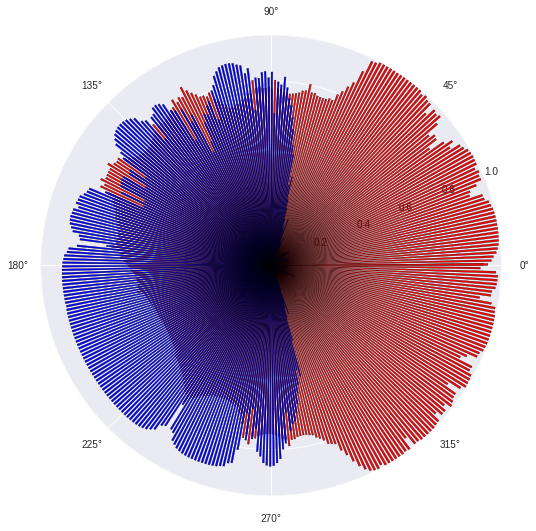

In [41]:
actinFinal=[]
myosinFinal=[]
D=SimData[4]
for i in range(0,COMPARTMENTS):
    actinFinal.append(D['Actin'+str(i)][-1]) 
    myosinFinal.append(D['Myosin'+str(i)][-1])
VALS=[]
VALS.append(myosinFinal)
VALS.append(actinFinal)

f=figure(figsize=(8,8))
ax=f.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
theta = np.linspace(0.0, 2.0*np.pi, 359)
C=['red','blue']
for i in range(0,len(VALS)):
    radii =  VALS[i]
    width = np.pi/359.0 
    bars = ax.bar(theta, radii, width=width, bottom=0.0)

    for r,bar in zip(radii, bars):
        bar.set_facecolor(C[i])
        bar.set_alpha(1.0)

In [42]:
import pickle
f=open('./simulationdata.dat','w')
pickle.dump(SimData,f)

# Plot final network configurations for different $\beta$ values

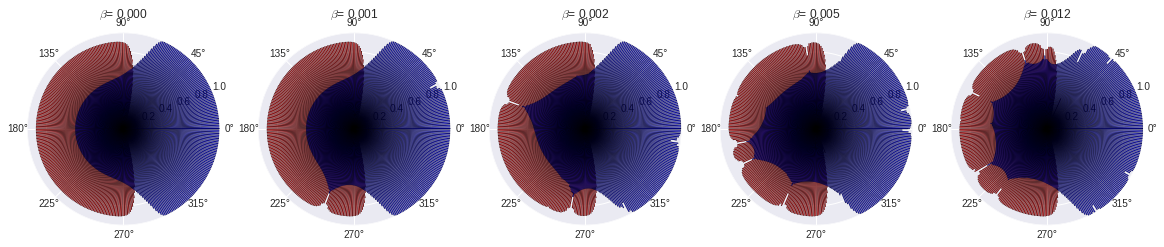

In [58]:
f, ax = plt.subplots(1,5, subplot_kw=dict(projection='polar'),figsize=(20,5))
for fig in range(0,5):
    actinFinal=[]
    myosinFinal=[]
    D=SimData[fig]
    for i in range(0,COMPARTMENTS):
        actinFinal.append(D['Actin'+str(i)][-1]) 
        myosinFinal.append(D['Myosin'+str(i)][-1])
    VALS=[]
    VALS.append(actinFinal)
    VALS.append(myosinFinal)

    theta = np.linspace(0.0, 2.0*np.pi, 359)
    C=['red','blue']
    for i in range(0,len(VALS)):
        radii =  VALS[i]
        width = np.pi/359.0 
        bars = ax[fig].bar(theta, radii, width=width, bottom=0.0)

        for r,bar in zip(radii, bars):
            bar.set_facecolor(C[i])
            bar.set_alpha(1.0)
    ax[fig].set_title('$\\beta$= %0.3f'%beta[fig])
plt.savefig('./cytoskeletal-network-rewiring.png')

# Generate animations

In [ ]:
COMPARTMENTS=359
data=[]
data.append(SimData[0])
data.append(SimData[5])
B=['0.000','0.012']
for t in tqdm(range(0,20)):
    f, ax = plt.subplots(1,2, subplot_kw=dict(projection='polar'),figsize=(10,5))
    for fig in range(0,2):
        actinFinal=[]
        myosinFinal=[]
        for i in range(0,COMPARTMENTS):
            actinFinal.append(data[fig]['Actin'+str(i)][t]) 
            myosinFinal.append(data[fig]['Myosin'+str(i)][t])
        VALS=[]
        VALS.append(actinFinal)
        VALS.append(myosinFinal)
        theta = np.linspace(0.0, 2.0*np.pi, 359)
        C=['red','blue']
        for i in range(0,len(VALS)):
            radii =  VALS[i]
            width = np.pi/359.0 
            bars = ax[fig].bar(theta, radii, width=width, bottom=0.0)

            for r,bar in zip(radii, bars):
                bar.set_facecolor(C[i])
                bar.set_alpha(1.0)
        ax[fig].set_title('$\\beta$='+B[fig])
    plt.savefig('./polarization-timecourse-t='+str(t)+'.png')

 65%|██████▌   | 13/20 [01:20<00:43,  0.16it/s]

# Generates Ligand distribution plots

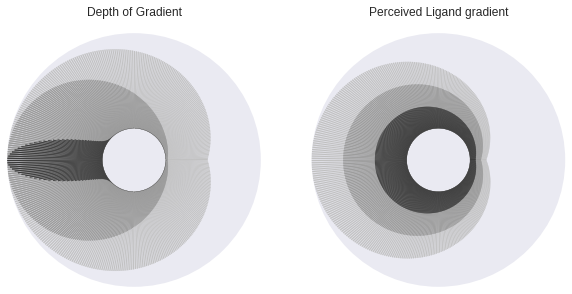

In [73]:
S=[0.1,0.5,1.1]
M=[0.5,1.0,1.5]
S.reverse()
M.reverse()
f, ax = plt.subplots(1,2, subplot_kw=dict(projection='polar'),figsize=(10,5))
theta = np.linspace(0.0, 2.0*np.pi, 359)
width = np.pi/359.0 
C=['#c0c0c0','#989898','#383838']
#C=['#DAECF3','#022D41','#1AA687']
#C=['#616536','#A4E666','#31B96E']
#C=['red','purple','blue']
i=0
for s in S:
    radii=initialLdist(358,1.5,s)
    bars = ax[0].bar(theta, radii, width=width, bottom=0.5,edgecolor=C[i])

    for r,bar in zip(radii, bars):
        bar.set_facecolor(C[i])
        bar.set_alpha(1.0)

    i=i+1
i=0
for m in M:
    radii=initialLdist(358,m,0.75)
    bars = ax[1].bar(theta, radii, width=width, bottom=0.5,edgecolor=C[i])

    for r,bar in zip(radii, bars):
        bar.set_facecolor(C[i])
        bar.set_alpha(1.0)
    i=i+1
    
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('Depth of Gradient')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('Perceived Ligand gradient')
#plt.savefig('./ligand-distribution.png',dpi=500)

# Generates consolidate heatmap collection of all variables with no rewiring

In [76]:
f=open('simulationdata.dat')
SimDat=pickle.load(f)

In [83]:
PTS=SimDat[0]

6


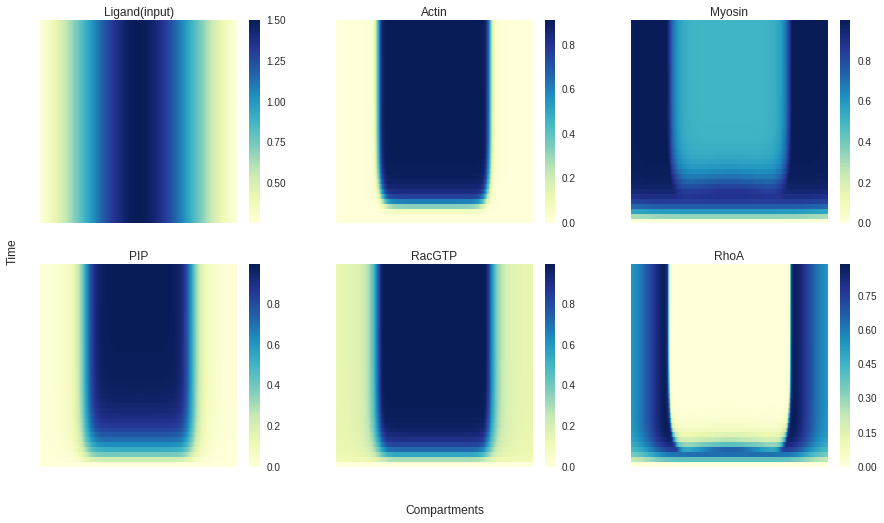

In [120]:
def makeheatmap(pointset):
    COMPARTMENTS=358
    pts=pointset
    col=[]
    mat=[]
    HEATMAPS=[]
    mat=[]
    LVALS=[]
    for i in range(0,len(pts['t'])):
        LVALS.append(initialLdist(358,1.5,0.75))
    HEATMAPS.append(LVALS)
    VARIABLES=['Actin','Myosin','PIP','RacGTP','RhoA']
    for string in VARIABLES:
        mat=[]
        col=[]
        for j in range(0,len(pts[string+'0'])):
            for i in range(0, COMPARTMENTS):
                col.append(pts[string+str(i)][j])
            mat.append(col)
            col=[]
        mat.reverse()
        HEATMAPS.append(mat)
    
    fig,ax=plt.subplots(2,3,figsize=[15,8],sharex=True, sharey=True)
    k=0
    print(len(HEATMAPS))
    NAMES=['Ligand(input)','Actin','Myosin','PIP','RacGTP','RhoA']

    fig.text(0.5, 0.05, 'Compartments', ha='center', va='center')
    fig.text(0.1, 0.5, 'Time', ha='center', va='center', rotation='vertical')
    for i in range(0,len(ax)):
        for j in range(0,len(ax[i])):
            ax[i][j].get_yaxis().set_visible(False)
            ax[i][j].get_xaxis().set_visible(False)
           
            ax[i][j].set_title(NAMES[k])
            sns.heatmap(HEATMAPS[k],ax=ax[i][j],cmap="YlGnBu")
            k=k+1
        
makeheatmap(PTS)
plt.savefig('./representative-results-compilation.png',dpi=500)

# Comparing strengths of ligand distribution

In [11]:
beta=[0.0]
A={}
graph=rewire(G.copy(),beta)
A=generate_adlist(graph)

COMPARTMENTS=N-1

RevisedCompArgs=dst.args(name='small-world-cyto',
        varspecs={
        # input set to constant initial value by default
        'L[i]':'for(i,0,'+str(COMPARTMENTS)+',0)',#kp-klr*L[i]*R[i]-kd)',
        'PIP[i]':'for(i,0,'+str(COMPARTMENTS)+',gamma_pip*(shs(S,wlr*L[i]*R[i]-wpip)-PIP[i]))',
        # Regulators
        'RacGTP[i]':"for(i,0,"+str(COMPARTMENTS)+",shs(S,-w_rac_rac*RacGTP[i]+w_rac_pip*PIP[i])-RacGTP[i])",
        'RhoA[i]':"for(i,0,"+str(COMPARTMENTS)+",(shs(S,wlr_rho*L[i]*R[i]-w_actin_rho*Actin[i])-RhoA[i]))",                   
    },
        pars={
# PIP Parameters
        'wpip':0.45,     
        'gamma_pip':0.5,
        'wlr':1.0,       
# RacGTP activation
        'w_rac_pip':3.0, 
# Rac
        'w_rac_rac':1.5,
# Rho
        'w_actin_rho':6.0,
        'wlr_rho':1.0,               
        'S':10,
        'kactin':1.0,#0.1,
        'w_actin':0.77,
        'k_actin_degr':1.0,
        'gamma_actin':10.0,
        'kmyosin':1.0,
        'k_degr_myosin':10
    },
                       ics={
    },
                       fnspecs={
        'shs':(['sig','summ'],'1.0/(1.0+exp(-sig*summ))'),
        'actinweight':(['n','denom'],'n/denom')
                               },
                       tdata=[0,20]
                       )
SimData=[]
act=[]
RevisedCompArgs.varspecs.update(actindefinition(A))
RevisedCompArgs.varspecs.update(myosindefinition(A))
# RevisedCompArgs.varspecs.update(actindefinition(B))
# RevisedCompArgs.varspecs.update(myosindefinition(B))
S=[0.01,0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.7,0.8,0.9,1.0]
#s=[0.5]
AMRatio=[]
#for v in s:
for s in tqdm(S):
    L=initialLdist(COMPARTMENTS,1.5,s)
    Rinitial=1.0
    PIPinitial=0.0
    Racinitial=0.0
    Actininital=0.0
    Rhoinitial=0.0
    Myosininitial=0.0
    for i in range(0,COMPARTMENTS+1):
        R=str('R'+str(i))
        RevisedCompArgs.pars[R]=Rinitial
        PIP=str('PIP'+str(i))
        RevisedCompArgs.ics[PIP]=PIPinitial
        Rac=str('RacGTP'+str(i))
        RevisedCompArgs.ics[Rac]=Racinitial
        Actin=str('Actin'+str(i))
        RevisedCompArgs.ics[Actin]=Actininital
        Rho=str('RhoA'+str(i))
        RevisedCompArgs.ics[Rho]=Rhoinitial
        Myosin=str('Myosin'+str(i))
        RevisedCompArgs.ics[Myosin]=Myosininitial
        Lval=str('L'+str(i))
        RevisedCompArgs.ics[Lval]=L[i]
    RevisedCompDS=dst.Vode_ODEsystem(RevisedCompArgs)
    pts=RevisedCompDS.compute('test').sample(dt=0.5)
    ratioVals=[]
    for j in range(0,COMPARTMENTS+1):
        ratioVals.append(pts['Actin'+str(j)][-1]/pts['Myosin'+str(j)][-1])
    AMRatio.append(ratioVals)
            

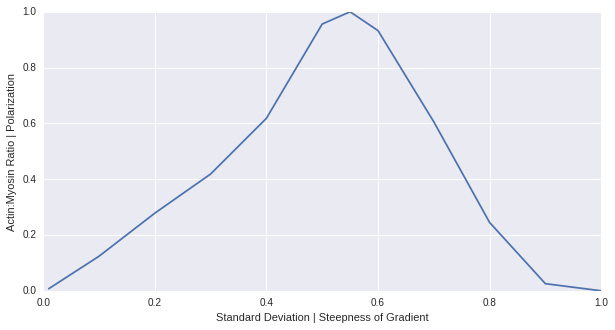

In [17]:
def minmaxnorm(A):
    MI=min(A)
    MA=max(A)
    B=[]
    for a in A:
        B.append((a-MI)/(MA-MI))
    return B
mag=[]
for i in range(0,len(AMRatio)):
    re=0
    im=0
    for j in range(0,len(AMRatio[0])):
        re=re+AMRatio[i][j]*np.cos(np.pi/180.0*j)
        im=im+AMRatio[i][j]*np.sin(np.pi/180.0*j)
    mag.append(np.sqrt(re**2+im**2))
plt.plot(S,minmaxnorm(mag))
plt.xlabel('Standard Deviation | Steepness of Gradient')
plt.ylabel('Actin:Myosin Ratio | Polarization')
plt.savefig('chemotaxis-phenotype-ligand-input.png',dpi=500)
# mag1=[]
# for s in S:
#     L=initialLdist(COMPARTMENTS,1.5,s)
#     for i in range(0,len(L)):
#         re=re+L[i]*np.cos(np.pi/180.0*i)
#         im=im+L[i]*np.sin(np.pi/180.0*i)
#     mag1.append(np.sqrt(re**2+im**2))
# plt.plot(S,minmaxnorm(mag1),'r')

# Effect of network randomization

In [18]:
beta=[0.0,0.012]
Adict=[]
for b in beta:
    A={}
    graph=rewire(G.copy(),beta)
    A=generate_adlist(graph)
    Adict.append(A)

COMPARTMENTS=N-1

RevisedCompArgs=dst.args(name='small-world-cyto',
        varspecs={
        # input set to constant initial value by default
        'L[i]':'for(i,0,'+str(COMPARTMENTS)+',0)',#kp-klr*L[i]*R[i]-kd)',
        'PIP[i]':'for(i,0,'+str(COMPARTMENTS)+',gamma_pip*(shs(S,wlr*L[i]*R[i]-wpip)-PIP[i]))',
        # Regulators
        'RacGTP[i]':"for(i,0,"+str(COMPARTMENTS)+",shs(S,-w_rac_rac*RacGTP[i]+w_rac_pip*PIP[i])-RacGTP[i])",
        'RhoA[i]':"for(i,0,"+str(COMPARTMENTS)+",(shs(S,wlr_rho*L[i]*R[i]-w_actin_rho*Actin[i])-RhoA[i]))",                   
    },
        pars={
# PIP Parameters
        'wpip':0.45,     
        'gamma_pip':0.5,
        'wlr':1.0,       
# RacGTP activation
        'w_rac_pip':3.0, 
# Rac
        'w_rac_rac':1.5,
# Rho
        'w_actin_rho':6.0,
        'wlr_rho':1.0,               
        'S':10,
        'kactin':1.0,#0.1,
        'w_actin':0.77,
        'k_actin_degr':1.0,
        'gamma_actin':10.0,
        'kmyosin':1.0,
        'k_degr_myosin':10
    },
                       ics={
    },
                       fnspecs={
        'shs':(['sig','summ'],'1.0/(1.0+exp(-sig*summ))'),
        'actinweight':(['n','denom'],'n/denom')
                               },
                       tdata=[0,20]
                       )
SimData=[]
act=[]

# RevisedCompArgs.varspecs.update(actindefinition(B))
# RevisedCompArgs.varspecs.update(myosindefinition(B))
S=[0.01,0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.7,0.8,0.9,1.0]
#s=[0.5]
ValueList=[]
for A in Adict:
    AMRatio=[]
    RevisedCompArgs.varspecs.update(actindefinition(A))
    RevisedCompArgs.varspecs.update(myosindefinition(A))
    #for v in s:
    for s in tqdm(S):
        L=initialLdist(COMPARTMENTS,1.5,s)
        Rinitial=1.0
        PIPinitial=0.0
        Racinitial=0.0
        Actininital=0.0
        Rhoinitial=0.0
        Myosininitial=0.0
        for i in range(0,COMPARTMENTS+1):
            R=str('R'+str(i))
            RevisedCompArgs.pars[R]=Rinitial
            PIP=str('PIP'+str(i))
            RevisedCompArgs.ics[PIP]=PIPinitial
            Rac=str('RacGTP'+str(i))
            RevisedCompArgs.ics[Rac]=Racinitial
            Actin=str('Actin'+str(i))
            RevisedCompArgs.ics[Actin]=Actininital
            Rho=str('RhoA'+str(i))
            RevisedCompArgs.ics[Rho]=Rhoinitial
            Myosin=str('Myosin'+str(i))
            RevisedCompArgs.ics[Myosin]=Myosininitial
            Lval=str('L'+str(i))
            RevisedCompArgs.ics[Lval]=L[i]
        RevisedCompDS=dst.Vode_ODEsystem(RevisedCompArgs)
        pts=RevisedCompDS.compute('test').sample(dt=0.5)
        ratioVals=[]
        for j in range(0,COMPARTMENTS+1):
            ratioVals.append(pts['Actin'+str(j)][-1]/pts['Myosin'+str(j)][-1])
        AMRatio.append(ratioVals)
    ValueList.append(AMRatio)

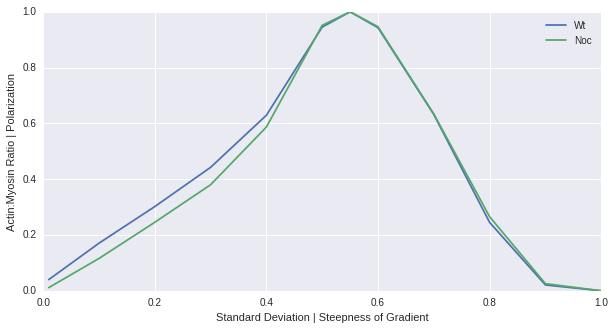

In [23]:
k=0
lab=['Wt','Noc']
for AMRatio in ValueList:
    mag=[]
    for i in range(0,len(AMRatio)):
        re=0
        im=0
        for j in range(0,len(AMRatio[0])):
            re=re+AMRatio[i][j]*np.cos(np.pi/180.0*j)
            im=im+AMRatio[i][j]*np.sin(np.pi/180.0*j)
        mag.append(np.sqrt(re**2+im**2))
    plt.plot(S,minmaxnorm(mag),label=lab[k])
    k=k+1
plt.legend()
plt.xlabel('Standard Deviation | Steepness of Gradient')
plt.ylabel('Actin:Myosin Ratio | Polarization')
plt.savefig('rewiring-comparison.png',dpi=500)

No statistical difference observable. This will be more meaningful with more random networks maybe?